In [1]:
import anndata as ad
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sys
import torch
import os
import matplotlib.pyplot as plt
import glob
import scanpy as sc

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Neighborhood overlap

In [2]:
def cdf(neighborhood_file):
    neighborhood = open(neighborhood_file,'r').readlines()
    neighborhood = [int(i.strip()) for i in neighborhood]
    neighborhood = np.array(neighborhood)
    
    Z = neighborhood / len(neighborhood)
    H,X = np.histogram( Z, bins = 1000, normed = True )
    dx = X[1] - X[0]
    F = np.cumsum(H)*dx
    return X, F

In [5]:
file_list = ['results/raw/neighborhood_s1d2_SiaNN.txt',
             #'results/raw/neighborhood_s1d2_glue.1.txt',
             'results/raw/neighborhood_s1d2_Seurat.txt',
             'results/raw/neighborhood_s1d2_bindSC.txt',
             'results/raw/neighborhood_s1d2_Liger.1.txt',
             'results/raw/neighborhood_s1d2_LigerINMF.1.txt']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been b

<Figure size 600x400 with 0 Axes>

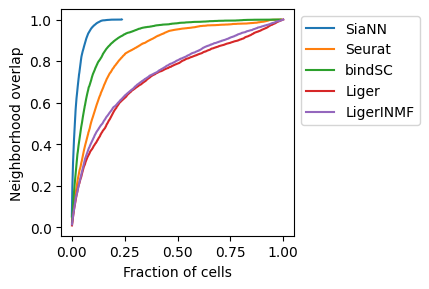

In [6]:
plt.rcParams['figure.dpi'] = 100

plt.clf()
fig, ax = plt.subplots(figsize=(3,3))

"""
file_list = ['SiaNN/neighborhood_s1d2_siaNN.txt',
             'seurat/neighborhood_s1d2_seurat.txt',
             'Liger/neighborhood_s1d2_liger.txt',
             'Liger/neighborhood_s1d2_liger.UMAP.txt',
             'Liger_online/neighborhood_s1d2_ligerOnline.txt',
             'Liger_online/neighborhood_s1d2_ligerOnline.UMAP.txt',
             'GLUE/neighborhood_s1d2_glue.txt',
             'bindSC/neighborhood_s1d2_bindSC.txt']
"""
method_list = []

for i in range(len(file_list)):
    method_id = file_list[i].split('_')[2].split('.')[0]
    X,F = cdf(file_list[i])
    plt.plot(X[1:], F)
    if 'UMAP' in file_list[i]:
        method_id = '%s (UMAP)'%(method_id)
    method_list.append(method_id)

ax.set_xlabel("Fraction of cells")
ax.set_ylabel("Neighborhood overlap")
ax.legend(method_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [7]:
file_list = ['results/raw/neighborhood_s3d7_SiaNN.txt',
             #'results/raw/neighborhood_s3d7_glue.1.txt',
             'results/raw/neighborhood_s3d7_Seurat.txt',
             'results/raw/neighborhood_s3d7_bindSC.txt',
             'results/raw/neighborhood_s3d7_Liger.1.txt',
             'results/raw/neighborhood_s3d7_LigerINMF.1.txt']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been b

<Figure size 600x400 with 0 Axes>

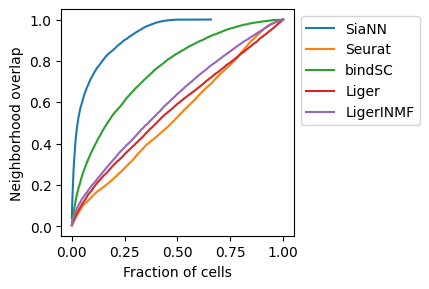

In [8]:
plt.rcParams['figure.dpi'] = 100

plt.clf()
fig, ax = plt.subplots(figsize=(3,3))

method_list = []

for i in range(len(file_list)):
    method_id = file_list[i].split('_')[2].split('.')[0]
    X,F = cdf(file_list[i])
    plt.plot(X[1:], F)
    if 'UMAP' in file_list[i]:
        method_id = '%s (UMAP)'%(method_id)
    method_list.append(method_id)

ax.set_xlabel("Fraction of cells")
ax.set_ylabel("Neighborhood overlap")
ax.legend(method_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### silhouette score

In [9]:
meta = pd.read_csv('cite.rna.meta.csv')

ct_int = meta['cell_type'].astype('category').cat.codes.to_numpy().astype('int')
ct_int = np.concatenate((ct_int,ct_int), axis=0)

tech_int = np.zeros(2*len(meta))
tech_int[len(meta):] = 1

batch_int = np.concatenate((meta['batch'].to_numpy(),
                            meta['batch'].to_numpy()), axis=0)


In [20]:
merge_list = glob.glob('results/raw/*embed.[1-9].txt') + glob.glob('results/raw/*embed.txt')
merge_list[0]

'results/raw/LigerINMF_embed.8.txt'

In [21]:
len(merge_list)
#merge_list

19

In [22]:
from sklearn.metrics import silhouette_score


method_id_list = []
for i in range(len(merge_list)):
    method_id = merge_list[i].split('/')[2].split('_')[0]
    if 'UMAP' in merge_list[i]:
        method_id = '%s (UMAP)'%(method_id)        
    method_id_list.append(method_id)

silh_score_df = pd.DataFrame({'method':method_id_list,
                              'cell_type_score':0,
                              'modality_score':0,
                              'batch_score':0})

for i in range(len(merge_list)):
    merge = pd.read_csv(merge_list[i]).iloc[:,1:].to_numpy()
    #bool_index = batch_int!='ss4d9'
    #merge = merge[bool_index]
    silh_score_df.iloc[i,1] = silhouette_score(merge, ct_int)
    silh_score_df.iloc[i,2] = 1 - silhouette_score(merge, tech_int)
    silh_score_df.iloc[i,3] = 1 - silhouette_score(merge, batch_int)


In [23]:
silh_score_df #all

,method,cell_type_score,modality_score,batch_score
0,LigerINMF,-0.112777,0.991530,0.859362
1,LigerINMF,-0.100160,0.994955,0.874455
2,Liger,-0.040792,0.991699,0.921265
3,LigerINMF,-0.098166,0.994279,0.842970
4,Liger,-0.034955,0.994824,0.869089
5,LigerINMF,-0.101255,0.994867,0.844327
6,LigerINMF,-0.100546,0.991785,0.844998
7,LigerINMF,-0.092883,0.992958,0.834416
8,Liger,-0.067178,0.992107,0.937889
9,Liger,-0.038380,0.995308,0.922744


In [24]:
silh_score_df.to_csv('results/silh_score.csv',index=False) #all

### Rand Index

In [2]:
meta = pd.read_csv('cite.rna.meta.csv')

ct_int = meta['cell_type'].astype('category').cat.codes.to_numpy().astype('int')
ct_int = np.concatenate((ct_int,ct_int), axis=0)

tech_int = np.zeros(2*len(meta))
tech_int[len(meta):] = 1

batch_int = np.concatenate((meta['batch'].to_numpy(),
                            meta['batch'].to_numpy()), axis=0)


In [3]:
merge_list = glob.glob('results/raw/*embed*')
merge_list = sorted(merge_list)
merge_list = np.array(merge_list)[[26,50,52,53]].tolist()
merge_list

['results/raw/Liger_embed.1.txt',
 'results/raw/Seurat_embed.pca.txt',
 'results/raw/SiaNN_embed.txt',
 'results/raw/bindSC_embed.txt']

In [4]:
method_id_list = ['Liger(UINMF)', 'Seurat', 'SiaNN', 'bindSC']


In [5]:
from sklearn.metrics.cluster import adjusted_rand_score

ARI_df = pd.DataFrame(np.zeros((0,3)))
ARI_df.columns = ['Method', '#Cluster', 'ARI']

In [6]:
for i in range(len(method_id_list)):

    merge = pd.read_csv(merge_list[i]).iloc[:,1:].to_numpy()
    ann_merge = ad.AnnData(
        X = merge
    )
    ann_merge.obs['cell_type'] = ct_int
    sc.pp.neighbors(ann_merge, use_rep='X', n_neighbors = 20)
    sc.tl.umap(ann_merge)
    for resol in range(1,31):
        if i == 1:
            sc.tl.leiden(ann_merge, resolution=resol/75)
        else:
            sc.tl.leiden(ann_merge, resolution=resol/10)
        n_clus = len(ann_merge.obs['leiden'].unique())
        ARI = adjusted_rand_score(ann_merge.obs['leiden'], ann_merge.obs['cell_type'])
        #print([method_id_list[0], n_clus, ARI])
        ARI_df.loc[-1] = [method_id_list[i], n_clus, ARI]
        ARI_df.index = ARI_df.index + 1
        ARI_df = ARI_df.sort_index()


merge = pd.read_csv('results/raw/Seurat_embed.pca.txt').iloc[:,1:].to_numpy()
ann_merge = ad.AnnData(
    X = merge
)
ann_merge.obs['cell_type'] = ct_int
sc.pp.neighbors(ann_merge, use_rep='X', n_neighbors = 20)
sc.tl.umap(ann_merge)
for resol in range(31,40):
    sc.tl.leiden(ann_merge, resolution=resol/75)
    n_clus = len(ann_merge.obs['leiden'].unique())
    ARI = adjusted_rand_score(ann_merge.obs['leiden'], ann_merge.obs['cell_type'])
    #print([method_id_list[0], n_clus, ARI])
    ARI_df.loc[-1] = ['Seurat', n_clus, ARI]
    ARI_df.index = ARI_df.index + 1
    ARI_df = ARI_df.sort_index()

In [8]:
merge = pd.read_csv('results/raw/SiaNN_embed.txt').iloc[:,1:].to_numpy()
ann_merge = ad.AnnData(
    X = merge
)
ann_merge.obs['cell_type'] = ct_int
sc.pp.neighbors(ann_merge, use_rep='X', n_neighbors = 20)
sc.tl.umap(ann_merge)
for resol in range(1,26):
    sc.tl.leiden(ann_merge, resolution=resol/50)
    n_clus = len(ann_merge.obs['leiden'].unique())
    ARI = adjusted_rand_score(ann_merge.obs['leiden'], ann_merge.obs['cell_type'])
    #print([method_id_list[0], n_clus, ARI])
    ARI_df.loc[-1] = ['SiaNN', n_clus, ARI]
    ARI_df.index = ARI_df.index + 1
    ARI_df = ARI_df.sort_index()

In [9]:
ARI_df.to_csv('results/ARI_score.csv',index=False) #all

### FOSCTTM

In [25]:
def foscttm(neighborhood_file):
    neighborhood = open(neighborhood_file,'r').readlines()
    neighborhood = [int(i.strip()) for i in neighborhood]
    neighborhood = np.array(neighborhood)
    
    return np.mean(neighborhood)/len(neighborhood)

In [26]:
file_list = glob.glob('results/raw/neigh*')
file_list[0]

'results/raw/neighborhood_s3d7_LigerINMF.7.txt'

In [27]:
len(file_list)

38

In [28]:
method_id_list = []
batch_list = []
for i in range(len(file_list)):
    method_id = file_list[i].split('_')[2].split('.')[0]
    if 'UMAP' in file_list[i]:
        method_id = '%s (UMAP)'%(method_id)        
    method_id_list.append(method_id)
    
    batch_id = file_list[i].split('neighborhood_')[1].split('_')[0]
    batch_list.append(batch_id)

foscttm_df = pd.DataFrame({'method':method_id_list,
                              'foscttm':0,
                              'batch':batch_list})

for i in range(len(file_list)):
    foscttm_df.iloc[i,1] = foscttm(file_list[i])

In [29]:
foscttm_df.sort_values('foscttm').iloc[0:20,:]

,method,foscttm,batch
31,SiaNN,0.025177,s1d2
8,SiaNN,0.078937,s3d7
24,bindSC,0.085630,s1d2
22,Seurat,0.146838,s1d2
17,LigerINMF,0.212636,s1d2
29,LigerINMF,0.215569,s1d2
13,LigerINMF,0.220464,s1d2
32,LigerINMF,0.221223,s1d2
35,LigerINMF,0.226124,s1d2
15,LigerINMF,0.226931,s1d2


In [30]:
foscttm_df.to_csv('results/foscttm_score.csv',index=False)

### Label transfer accuracy

In [35]:
file_list = glob.glob('results/raw/*acc*')
file_list = sorted(file_list)
file_list[0]

'results/raw/LigerINMF_transfer_acc.1.csv'

In [36]:
len(file_list)

19

In [37]:
method_id_list = []
for i in range(len(file_list)):
    method_id = file_list[i].split('/')[2].split('_')[0]
    if 'UMAP' in file_list[i]:
        method_id = '%s (UMAP)'%(method_id)        
    method_id_list.append(method_id)

pred_df = pd.read_csv(file_list[0],index_col=0)
pred_df

acc_ct_df = pd.DataFrame(np.zeros((len(file_list), pred_df.shape[0]+1)))

In [38]:
acc_ct_df.columns = ['method'] + pred_df['cell_type'].tolist()
acc_ct_df['method'] = method_id_list

In [39]:
for i in range(len(file_list)):
    if method_id_list[i] == 'Seurat':
        seurat = pd.read_csv(file_list[i])
        seurat = seurat.loc[seurat['Var1']==seurat['Var2'],:]
        seurat = seurat.iloc[:,2:]
        seurat.index = seurat['Var2'].to_numpy()
        seurat.columns = ['cell_type', 'Seurat']
        preded_ct = np.intersect1d(acc_ct_df.columns[1:],seurat.index)
        unpreded_ct = np.setdiff1d(acc_ct_df.columns[1:],seurat.index)
        seurat.insert
        for ct in unpreded_ct:
            seurat.loc[-1] = [ct, 0.0]
            seurat.index = seurat.index[0:-1].tolist() + [ct]
        seurat = seurat.loc[acc_ct_df.columns[1:],:]
        assert np.all(acc_ct_df.columns[1:].to_numpy() == seurat['cell_type'].to_numpy())
        acc_ct_df.iloc[i,1:] = seurat.iloc[:,1].to_numpy()
    else:
        pred_df = pd.read_csv(file_list[i],index_col=0)
        assert np.all(acc_ct_df.columns[1:].to_numpy() == pred_df['cell_type'].to_numpy())
        acc_ct_df.iloc[i,1:] = pred_df.iloc[:,1].to_numpy()

In [41]:
file_list_2 = glob.glob('results/raw/*prediction*')
file_list_2 = sorted(file_list_2)
file_list_2[0]

'results/raw/LigerINMF_prediction.1.txt'

In [42]:
method_id_list = []
for i in range(len(file_list_2)):
    method_id = file_list_2[i].split('/')[2].split('_')[0]
    if 'UMAP' in file_list_2[i]:
        method_id = '%s (UMAP)'%(method_id)        
    method_id_list.append(method_id)


acc_df = pd.DataFrame({'method':method_id_list,
                              'total_acc':0})

for i in range(len(file_list_2)):
    pred_df = pd.read_csv(file_list_2[i])
    acc_df.iloc[i,1] = np.mean(pred_df['cell_type'] == pred_df['prediction'])




In [43]:
acc_ct_df.insert(1, 'total', acc_df['total_acc'].to_numpy())

In [44]:
acc_ct_df

,method,total,Transitional B,NK,CD4+ T,ILC,CD14+ Mono,MAIT,cDC,Reticulocyte,...,T reg,HSC,Lymph prog,Plasma,Normoblast,pDC,Proerythroblast,MK/E prog,T prog cycling,dnT
0,LigerINMF,0.419870,0.382979,0.456929,0.423690,0.000000,0.631776,0.005682,0.002786,0.163743,...,0.00,0.000000,0.170732,0.280303,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,LigerINMF,0.422029,0.393617,0.466916,0.578588,0.000000,0.627869,0.068182,0.000000,0.068226,...,0.00,0.000000,0.054878,0.333333,0.000000,0.015584,0.000000,0.000000,0.0,0.000000
2,LigerINMF,0.446985,0.425532,0.496255,0.486902,0.000000,0.662380,0.005682,0.005571,0.058480,...,0.00,0.000000,0.158537,0.257576,0.000000,0.018182,0.000000,0.000000,0.0,0.000000
3,LigerINMF,0.468231,0.393617,0.483770,0.613895,0.000000,0.724890,0.011364,0.000000,0.074074,...,0.00,0.000000,0.140244,0.265152,0.000000,0.023377,0.000000,0.000000,0.0,0.000000
4,LigerINMF,0.488534,0.452128,0.581773,0.595103,0.000000,0.741006,0.022727,0.000000,0.091618,...,0.00,0.000000,0.079268,0.295455,0.000000,0.010390,0.000000,0.000000,0.0,0.000000
5,LigerINMF,0.440173,0.414894,0.409488,0.633257,0.000000,0.659287,0.039773,0.000000,0.085770,...,0.00,0.000000,0.121951,0.242424,0.000000,0.007792,0.000000,0.000000,0.0,0.000000
6,LigerINMF,0.430258,0.457447,0.522472,0.493736,0.000000,0.630799,0.005682,0.000000,0.087719,...,0.00,0.000000,0.146341,0.280303,0.000000,0.012987,0.000000,0.000000,0.0,0.000000
7,LigerINMF,0.448334,0.489362,0.502497,0.466401,0.000000,0.668403,0.039773,0.002786,0.150097,...,0.00,0.000000,0.042683,0.446970,0.000000,0.033766,0.000000,0.000000,0.0,0.000000
8,Liger,0.498314,0.372340,0.512484,0.554100,0.000000,0.790493,0.000000,0.002786,0.000000,...,0.00,0.000000,0.000000,0.015152,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,Liger,0.588898,0.553191,0.668539,0.620159,0.000000,0.923165,0.005682,0.002786,0.368421,...,0.00,0.000000,0.042683,0.280303,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [45]:
acc_ct_df.to_csv('results/label_trasfer_acc.csv',index=False)